# Load data

In [44]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('egd').getOrCreate()

df_class = spark.read.format("csv").option("header", "false").option("inferSchema", "true").option("charset", "UTF-8").load("gs://bucket_20023/sentiment.csv")

cols = ['sentiment','id','date','query_string','user','text']
df_class = df_class.toDF(*cols)

In [45]:
import numpy as np
import matplotlib.pyplot as plt

df_class.show(5)

+---------+----------+--------------------+------------+---------------+--------------------+
|sentiment|        id|                date|query_string|           user|                text|
+---------+----------+--------------------+------------+---------------+--------------------+
|        0|1467810369|Mon Apr 06 22:19:...|    NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|        0|1467810672|Mon Apr 06 22:19:...|    NO_QUERY|  scotthamilton|is upset that he ...|
|        0|1467810917|Mon Apr 06 22:19:...|    NO_QUERY|       mattycus|@Kenichan I dived...|
|        0|1467811184|Mon Apr 06 22:19:...|    NO_QUERY|        ElleCTF|my whole body fee...|
|        0|1467811193|Mon Apr 06 22:19:...|    NO_QUERY|         Karoli|@nationwideclass ...|
+---------+----------+--------------------+------------+---------------+--------------------+
only showing top 5 rows



In [46]:
from pyspark.sql.functions import count

counts = df_class.groupBy("sentiment").agg(count("*").alias("count"))
counts.show()

+---------+------+
|sentiment| count|
+---------+------+
|        4|800000|
|        0|800000|
+---------+------+



In [47]:
df = df_class.drop("id", "date", "query_string", "user")

In [48]:
df.filter(df.sentiment == 0).take(10)

[Row(sentiment=0, text="@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"),
 Row(sentiment=0, text="is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"),
 Row(sentiment=0, text='@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'),
 Row(sentiment=0, text='my whole body feels itchy and like its on fire '),
 Row(sentiment=0, text="@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "),
 Row(sentiment=0, text='@Kwesidei not the whole crew '),
 Row(sentiment=0, text='Need a hug '),
 Row(sentiment=0, text="@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?"),
 Row(sentiment=0, text="@Tatiana_K nope they didn't have it "),
 Row(sentiment=0, text='@twittera que me muera ? ')]

In [49]:
df.filter(df.sentiment == 4).take(10)

[Row(sentiment=4, text='I LOVE @Health4UandPets u guys r the best!! '),
 Row(sentiment=4, text='im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!'),
 Row(sentiment=4, text='@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart. '),
 Row(sentiment=4, text='Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup'),
 Row(sentiment=4, text='@LovesBrooklyn2 he has that effect on everyone '),
 Row(sentiment=4, text='@ProductOfFear You can tell him that I just burst out laughing really loud because of that  Thanks for making me come out of my sulk!'),
 Row(sentiment=4, text='@r_keith_hill Thans for your response. Ihad already find this answer '),
 Row(sentiment=4, text="@KeepinUpWKris I am so jealous, hope you had a great time in vegas! how did you like the ACM's?! LOVE YOUR SHOW!! "),
 Row(sentiment=4, text='@tommcfly ah, congrats mr fletch

<b>Data Preparation</b>

In [50]:
from pyspark.sql.functions import length

df = df.withColumn("pre_clean_len", length(df.text))
df.show(10)

+---------+--------------------+-------------+
|sentiment|                text|pre_clean_len|
+---------+--------------------+-------------+
|        0|@switchfoot http:...|          115|
|        0|is upset that he ...|          111|
|        0|@Kenichan I dived...|           89|
|        0|my whole body fee...|           47|
|        0|@nationwideclass ...|          111|
|        0|@Kwesidei not the...|           29|
|        0|         Need a hug |           11|
|        0|@LOLTrish hey  lo...|           99|
|        0|@Tatiana_K nope t...|           36|
|        0|@twittera que me ...|           25|
+---------+--------------------+-------------+
only showing top 10 rows



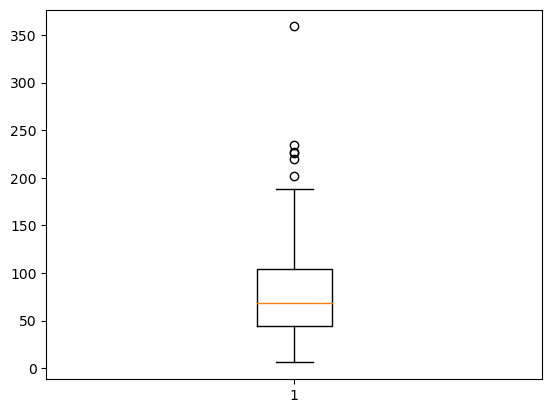

In [51]:
import matplotlib.pyplot as plt

pre_clean_len_list = df.select("pre_clean_len").rdd.flatMap(lambda x: x).collect()
plt.boxplot(pre_clean_len_list)
plt.show()

In [52]:
df.filter(df.pre_clean_len > 140).show(10)

+---------+--------------------+-------------+
|sentiment|                text|pre_clean_len|
+---------+--------------------+-------------+
|        0|Awwh babs... you ...|          142|
|        0|Whinging. My clie...|          145|
|        0|@TheLeagueSF Not ...|          145|
|        0|#3 woke up and wa...|          144|
|        0|My bathtub drain ...|          146|
|        0|pears &amp; Brie,...|          150|
|        0|Have an invite fo...|          141|
|        0|Damnit I was real...|          141|
|        0|Why do I keep loo...|          141|
|        0|Used the term &qu...|          148|
+---------+--------------------+-------------+
only showing top 10 rows



<b>Data Preparation 1: HTML decoding</b>

In [53]:
#pip install lxml

<b>Data Preparation 2: ‘@’mention</b>

<b>Data Preparation 3: URL links</b>

<b>Data Preparation 4: UTF-8 BOM (Byte Order Mark)</b>

<b>Data Preparation 5: hashtag / numbers</b>

In [54]:
#!pip install nltk

In [55]:
#!pip install regex

<b>Now in one function with enhancment from Part II</b>

In [56]:
from bs4 import BeautifulSoup
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
#import nltk
#nltk.download('punkt')

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
                 "haven't": "have not","hasn't": "has not","hadn't": "had not","won't": "will not",
                 "wouldn't": "would not","don't": "do not","doesn't": "does not","didn't": "did not",
                 "can't": "can not","couldn't": "could not","shouldn't": "should not","mightn't": "might not",
                 "mustn't": "must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.encode("utf-8-sig")
        bom_removed = bom_removed.decode("utf-8-sig").replace("[^\x00-\x7F]+","?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x in re.findall(r'\w+', letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

tweet_cleaner_udf = udf(tweet_cleaner, StringType())

In [57]:
from pyspark.sql.functions import monotonically_increasing_id
df_with_index = df.rdd.zipWithIndex().toDF(["data", "index"]).select("data.*", "index")

In [58]:
df_with_index.show()

+---------+--------------------+-------------+-----+
|sentiment|                text|pre_clean_len|index|
+---------+--------------------+-------------+-----+
|        0|@switchfoot http:...|          115|    0|
|        0|is upset that he ...|          111|    1|
|        0|@Kenichan I dived...|           89|    2|
|        0|my whole body fee...|           47|    3|
|        0|@nationwideclass ...|          111|    4|
|        0|@Kwesidei not the...|           29|    5|
|        0|         Need a hug |           11|    6|
|        0|@LOLTrish hey  lo...|           99|    7|
|        0|@Tatiana_K nope t...|           36|    8|
|        0|@twittera que me ...|           25|    9|
|        0|spring break in p...|           43|   10|
|        0|I just re-pierced...|           26|   11|
|        0|@caregiving I cou...|           94|   12|
|        0|@octolinz16 It it...|           77|   13|
|        0|@smarrison i woul...|          117|   14|
|        0|@iamjazzyfizzle I...|          103|

In [59]:
import time

In [60]:
clean_tweet_udf = udf(tweet_cleaner, StringType())
# Start measuring time
start_time = time.time()
df22 = df.withColumn("cleaned_text", clean_tweet_udf("text"))
end_time = time.time()
execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")

df22.show()

Execution Time: 0.02125859260559082 seconds
+---------+--------------------+-------------+--------------------+
|sentiment|                text|pre_clean_len|        cleaned_text|
+---------+--------------------+-------------+--------------------+
|        0|@switchfoot http:...|          115|awww that bummer ...|
|        0|is upset that he ...|          111|is upset that he ...|
|        0|@Kenichan I dived...|           89|dived many times ...|
|        0|my whole body fee...|           47|my whole body fee...|
|        0|@nationwideclass ...|          111|no it not behavin...|
|        0|@Kwesidei not the...|           29|  not the whole crew|
|        0|         Need a hug |           11|            need hug|
|        0|@LOLTrish hey  lo...|           99|hey long time no ...|
|        0|@Tatiana_K nope t...|           36|nope they did not...|
|        0|@twittera que me ...|           25|        que me muera|
|        0|spring break in p...|           43|spring break in p...|
|   

In [61]:
df22.show(5)

+---------+--------------------+-------------+--------------------+
|sentiment|                text|pre_clean_len|        cleaned_text|
+---------+--------------------+-------------+--------------------+
|        0|@switchfoot http:...|          115|awww that bummer ...|
|        0|is upset that he ...|          111|is upset that he ...|
|        0|@Kenichan I dived...|           89|dived many times ...|
|        0|my whole body fee...|           47|my whole body fee...|
|        0|@nationwideclass ...|          111|no it not behavin...|
+---------+--------------------+-------------+--------------------+
only showing top 5 rows



In [62]:
# Note that df is not changed as Dataframes are immutable
Other_df=df22.na.drop()
Other_df.show()

+---------+--------------------+-------------+--------------------+
|sentiment|                text|pre_clean_len|        cleaned_text|
+---------+--------------------+-------------+--------------------+
|        0|@switchfoot http:...|          115|awww that bummer ...|
|        0|is upset that he ...|          111|is upset that he ...|
|        0|@Kenichan I dived...|           89|dived many times ...|
|        0|my whole body fee...|           47|my whole body fee...|
|        0|@nationwideclass ...|          111|no it not behavin...|
|        0|@Kwesidei not the...|           29|  not the whole crew|
|        0|         Need a hug |           11|            need hug|
|        0|@LOLTrish hey  lo...|           99|hey long time no ...|
|        0|@Tatiana_K nope t...|           36|nope they did not...|
|        0|@twittera que me ...|           25|        que me muera|
|        0|spring break in p...|           43|spring break in p...|
|        0|I just re-pierced...|           26|ju

In [63]:
df22.filter(df.text.isNull()).show()

+---------+----+-------------+------------+
|sentiment|text|pre_clean_len|cleaned_text|
+---------+----+-------------+------------+
+---------+----+-------------+------------+



In [64]:
df22.filter(df.sentiment.isNull()).show()

+---------+----+-------------+------------+
|sentiment|text|pre_clean_len|cleaned_text|
+---------+----+-------------+------------+
+---------+----+-------------+------------+



In [65]:
df22 = df22.drop("text","pre_clean_len","processed_text")

In [66]:
df22.show(5)

+---------+--------------------+
|sentiment|        cleaned_text|
+---------+--------------------+
|        0|awww that bummer ...|
|        0|is upset that he ...|
|        0|dived many times ...|
|        0|my whole body fee...|
|        0|no it not behavin...|
+---------+--------------------+
only showing top 5 rows



In [35]:
"""from pyspark.ml.feature import StopWordsRemover
import pyspark.sql.functions as F
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stopsWords = set(stopwords.words('english'))

my_stop_words = ["get", "going", "go", "got", "one", "im", "lol"]

stopsWords = stopsWords.union(my_stop_words)
stopsWords = list(stopsWords)

df_tokens = df22.withColumn("tokens", F.split("cleaned_text", "\\s+"))
remover = StopWordsRemover(stopWords=stopsWords, inputCol="tokens", outputCol="stop")

df_tokens = remover.transform(df_tokens).select("sentiment", F.array_join("stop", " ").alias("cleaned_text"))

df_tokens.show(5)"""

AttributeError: module 'regex' has no attribute 'Pattern'

In [ ]:
from pyspark.ml.feature import StopWordsRemover
import pyspark.sql.functions as F

stopsWords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
              "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers",
              "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
              "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
              "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does",
              "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until",
              "while", "of", "at", "by", "for", "with", "about", "against", "between", "into",
              "through", "during", "before", "after", "above", "below", "to", "from", "up", "down",
              "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
              "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more",
              "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
              "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "d",
              "ll", "m", "o", "re", "ve", "y", "ain", "aren", "couldn", "didn", "doesn", "hadn",
              "hasn", "haven", "isn", "ma", "mightn", "mustn", "needn", "shan", "shouldn", "wasn",
              "weren", "won", "wouldn"]

my_stop_words = ["get", "going", "go", "got", "one", "im", "lol"]

stopsWords = stopsWords + my_stop_words

df_tokens = df22.withColumn("tokens", F.split("cleaned_text", "\\s+"))
remover = StopWordsRemover(stopWords=stopsWords, inputCol="tokens", outputCol="stop")

df_tokens = remover.transform(df_tokens).select("sentiment", F.array_join("stop", " ").alias("cleaned_text"))

df_tokens.show(5)


In [ ]:
df22 = df_tokens
df22.show(5)

In [27]:
df_filtered = df22.filter(df22.sentiment == 0)
df_filtered.show(truncate=False)

+---------+---------------------------------------------------------------------------------------------------------+
|sentiment|cleaned_text                                                                                             |
+---------+---------------------------------------------------------------------------------------------------------+
|0        |awww that bummer you shoulda got david carr of third day to do it                                        |
|0        |is upset that he can not update his facebook by texting it and might cry as result school today also blah|
|0        |dived many times for the ball managed to save the rest go out of bounds                                  |
|0        |my whole body feels itchy and like its on fire                                                           |
|0        |no it not behaving at all mad why am here because can not see you all over there                         |
|0        |not the whole crew                           

# Data Analysis

## Class distribution

In [23]:
# Count the number of instances of each class
from pyspark.sql.functions import when
df22 = df22.withColumn("sentiment", when(df.sentiment == 4, 1).otherwise(df.sentiment))

df_class = df22.groupBy("sentiment").count()

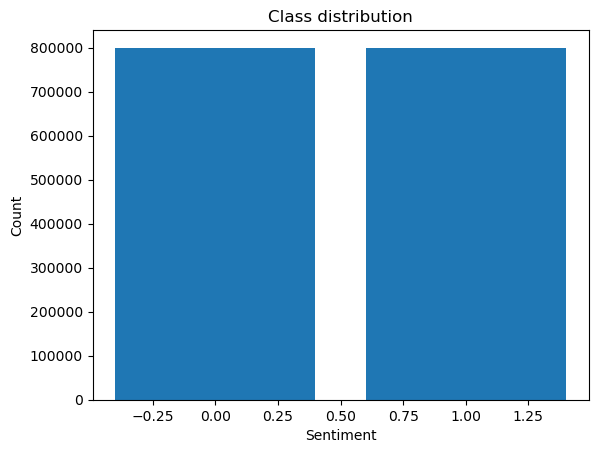

In [29]:
# Transform the result into a pandas dataframe
df_class_pd = df_class.toPandas()

# Creates a vertical bar chart
plt.bar(df_class_pd['sentiment'], df_class_pd['count'])

# Set the legend and title of the chart
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Class distribution')

# Plot the figure
plt.show()

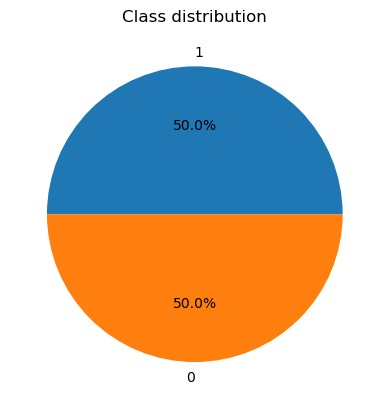

In [30]:
# Create a pie chart
plt.pie(df_class_pd['count'], labels=df_class_pd['sentiment'], autopct='%1.1f%%')

# Set the title of the figure
plt.title('Class distribution')

# Plot the figure
plt.show()

In [31]:
## Most frequent words

In [32]:
from pyspark.sql.functions import explode, split

words = df22.select(explode(split(df22.cleaned_text, "\s+")).alias("word"))
wordCounts = words.groupBy("word").count()
wordCounts = wordCounts.orderBy("count", ascending=False)

numberWords = 10

wordCounts.show(numberWords)

+----+------+
|word| count|
+----+------+
|  to|565729|
| the|523834|
|  my|316730|
|  it|305234|
| and|303600|
| you|302089|
| not|281589|
|  is|244623|
|  in|216702|
| for|216368|
+----+------+
only showing top 10 rows



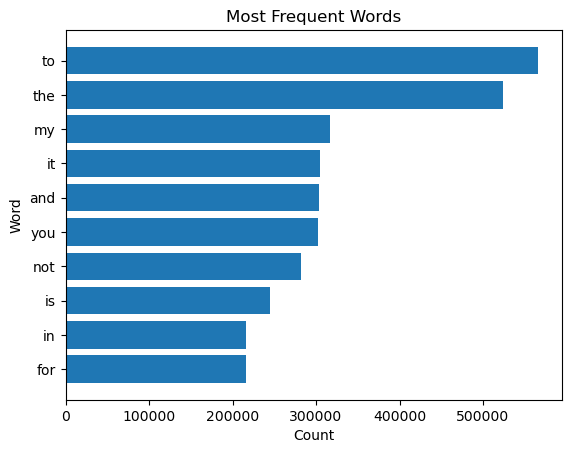

In [33]:
# Transform the result into a pandas dataframe
wordCounts_pd = wordCounts.limit(numberWords).toPandas()

# Create a horizontal bar plot
plt.barh(wordCounts_pd['word'], wordCounts_pd['count'])

# Set the legend and title of the figure
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Most Frequent Words')
plt.gca().invert_yaxis()

# Plot the figure
plt.show()

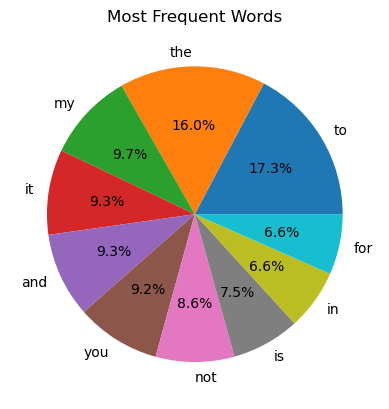

In [34]:
# Create a pie chart
plt.pie(wordCounts_pd['count'], labels=wordCounts_pd['word'], autopct='%1.1f%%')

# Set the title of the figure
plt.title('Most Frequent Words')

# Plot the figure
plt.show()

## Word Cloud

In [39]:
#!pip install wordcloud

### Ngram = 1

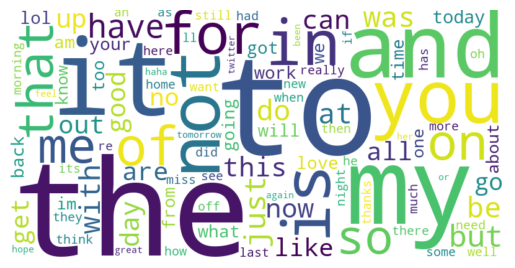

In [38]:
from wordcloud import WordCloud

wordCounts_pd = wordCounts.limit(numberWords * 10).toPandas()

# Generate the word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordCounts_pd.set_index('word')['count'].to_dict())
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Ngram = 2

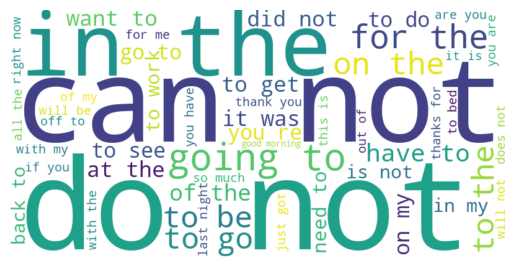

In [40]:
from pyspark.ml.feature import NGram
from pyspark.sql.functions import col

# Split data
df_tokens = df22.select(split("cleaned_text", "\s+").alias("words"))

# Generate n-grams from tokenized text
ngram = NGram(n=2, inputCol="words", outputCol="ngrams")
df_ngrams = ngram.transform(df_tokens).select("ngrams")

# Count the frequency of ngram and sort
df_ngramcounts = df_ngrams.select(explode(col("ngrams")).alias("ngram")).groupBy("ngram").count().orderBy("count", ascending=False)

# Convert frequency count to Pandas dataframe
pd_ngramcounts = df_ngramcounts.limit(numberWords * 5).toPandas()

# Plot word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(pd_ngramcounts.set_index('ngram')['count'].to_dict())
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<b>Machine Learning</b>

In [100]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col, rand
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LogisticRegression
import time
from pyspark.ml.classification import GBTClassifier

<i>In order to make sure that the dataset is splitted the right way between trainning and test, we will perform a stratified split instead of a random split. We will use the stratify parameter of the randomSplit method in PySpark. However, PySpark does not natively support stratified splits out of the box. So, to achieve a stratified split we will use the stratifiedSample method from the pyspark.sql.DataFrameStatFunctions</i>


In [68]:
%%time

# Select relevant columns and filter null values
data = df22.select('cleaned_text', 'sentiment').filter("cleaned_text is not NULL and sentiment is not NULL")

# Feature extraction
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="words")
wordsData = tokenizer.transform(data)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
featurizedData = hashingTF.transform(wordsData)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

# Calculate class distribution
class_distribution = rescaledData.groupBy("sentiment").count()

# Calculate fractions for stratified sampling
fractions = class_distribution.select("sentiment", (1.0 * class_distribution["count"] / rescaledData.count()).alias("fraction")).rdd.collectAsMap()

# Perform stratified sampling
stratified_data = rescaledData.sampleBy("sentiment", fractions=fractions, seed=100)

# Split the data
(trainingData, testData) = stratified_data.randomSplit([0.7, 0.3], seed=100)

CPU times: user 118 ms, sys: 35.3 ms, total: 153 ms
Wall time: 10min 36s


<b>Naive Bayes</b>

<i>Naive Bayes is a supervised machine learning algorithm that is based on Bayes theorem. It is particularly popular for text classification tasks, such as spam filtering, sentiment analysis, and document categorization. The key assumption of Naive Bayes is that the features (words or other attributes) are conditionally independent given the class label. This assumption is considered "naive" because it simplifies the calculation of probabilities, making the algorithm computationally efficient.</i>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%%time

# Train the model
nb = NaiveBayes(labelCol="sentiment", featuresCol="features", smoothing=1.0, modelType="multinomial")
model = nb.fit(trainingData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="sentiment")
predictions = model.transform(testData)

predictions = predictions.withColumn('sentiment', col('sentiment').cast('float'))

# Compute evaluation metrics
naive_accuracy = evaluator.evaluate(predictions)
print("Accuracy:", naive_accuracy)

# Compute precision, recall, f1-score and AUC
labels = predictions.select('sentiment').distinct().rdd.flatMap(lambda x: x).collect()
metrics = MulticlassMetrics(predictions.select("prediction", "sentiment").rdd)

# Calculate precision, recall, and F1 score
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedPrecision")
naive_precision = evaluator.evaluate(predictions)
print("Precision: ", naive_precision)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedRecall")
naive_recall = evaluator.evaluate(predictions)
print("Recall: ", naive_recall)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")
naive_f1_score = evaluator.evaluate(predictions)
print("F1 Score: ", naive_f1_score)

    
# Create a binary classification evaluator with metric set to AUC
evaluator = BinaryClassificationEvaluator(labelCol="sentiment", metricName="areaUnderROC")
naive_auc = evaluator.evaluate(predictions)
print("AUC:", naive_auc)


Accuracy: 0.7117996954575985


Precision:  0.7118317513866683


Recall:  0.711805541095976


F1 Score:  0.7117996954575985


AUC: 0.5382237366828329
CPU times: user 348 ms, sys: 59.5 ms, total: 407 ms
Wall time: 29min 33s


<b>LogisticRegression with Maximum Entropy</b>

<i>Logistic Regression with Maximum Entropy, often referred to simply as Logistic Regression or MaxEnt, is a popular statistical model used for binary classification tasks. It is based on the concept of maximum entropy, which aims to find the model that makes the least assumptions about the data while still being consistent with the observed information.</i>

In [ ]:
%%time
from pyspark.ml.classification import LogisticRegression

# Train the model
lr = LogisticRegression(labelCol="sentiment", featuresCol="features", maxIter=10, regParam=0.01)
model = lr.fit(trainingData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="sentiment")
predictions = model.transform(testData)

predictions = predictions.withColumn('sentiment', col('sentiment').cast('float'))

# Compute evaluation metrics
maxent_accuracy = evaluator.evaluate(predictions)
print("Accuracy:", maxent_accuracy)

# Compute precision, recall, f1-score and AUC
labels = predictions.select('sentiment').distinct().rdd.flatMap(lambda x: x).collect()
metrics = MulticlassMetrics(predictions.select("prediction", "sentiment").rdd)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedPrecision")
maxent_precision = evaluator.evaluate(predictions)
print("Precision: ", maxent_precision)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedRecall")
maxent_recall = evaluator.evaluate(predictions)
print("Recall: ", maxent_recall)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")
maxent_f1_score = evaluator.evaluate(predictions)
print("F1 Score: ", maxent_f1_score)
      
# Compute AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="sentiment", metricName="areaUnderROC")
maxent_auc = binary_evaluator.evaluate(predictions)
print("AUC:", maxent_auc)



23/05/03 21:55:47 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/05/03 21:55:47 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Accuracy: 0.7259310225563085


Precision:  0.7281647957381777


Recall:  0.7279174457488142


F1 Score:  0.7278347040523063


AUC: 0.7962478160427505
CPU times: user 397 ms, sys: 68.6 ms, total: 466 ms
Wall time: 32min 3s


<b>Random Forest</b>

<i>This model is an ensemble learning algorithm that combines multiple decision trees to make a final prediction. It works by creating a set of decision trees, each trained on a random subset of the input data.</i>

In [ ]:
%%time
from pyspark.ml.classification import RandomForestClassifier

# Train the model
rf = RandomForestClassifier(labelCol="sentiment", featuresCol="features", numTrees=10, maxDepth=10, seed=42)
model = rf.fit(trainingData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="sentiment")
predictions = model.transform(testData)

predictions = predictions.withColumn('sentiment', col('sentiment').cast('float'))

# Compute evaluation metrics
rf_accuracy = evaluator.evaluate(predictions)
print("Accuracy:", rf_accuracy)

# Compute precision, recall, f1-score and AUC
labels = predictions.select('sentiment').distinct().rdd.flatMap(lambda x: x).collect()
metrics = MulticlassMetrics(predictions.select("prediction", "sentiment").rdd)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedPrecision")
rf_precision = evaluator.evaluate(predictions)
print("Precision: ", rf_precision)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedRecall")
rf_recall = evaluator.evaluate(predictions)
print("Recall: ", rf_recall)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")
rf_f1_score = evaluator.evaluate(predictions)
print("F1 Score: ", rf_f1_score)
      
# Compute AUC
binary_evaluator = evaluator.setMetricName("accuracy").setLabelCol("sentiment")
rf_auc = binary_evaluator.evaluate(predictions)
print("AUC:", rf_auc)

Accuracy: 0.658640428276251


Precision:  0.6586957466703521


Recall:  0.6586641569463589


F1 Score:  0.658640428276251


AUC: 0.6586641569463589
CPU times: user 497 ms, sys: 101 ms, total: 597 ms
Wall time: 45min 20s


<b>GBoost</b>

<i>Gradient Boosted Trees: This model is also an ensemble learning algorithm that combines multiple weak models to make a final prediction. 
It works by creating a series of decision trees, each trained on the errors of the previous tree.</i>

In [87]:
from pyspark.sql.functions import when

df_GBOOST = stratified_data.withColumn("sentiment", when(stratified_data["sentiment"] == 4, 1).otherwise(stratified_data["sentiment"]))

In [88]:
(trainingData, testData) = df_GBOOST.randomSplit([0.7, 0.3], seed=100)

In [ ]:
%%time
# Configure the feature extraction pipeline
gbt = GBTClassifier(featuresCol="features", labelCol="sentiment")

#pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, gbt])

# Train the GBT model
model = gbt.fit(trainingData)

# Make predictions on the testing data
predictions = model.transform(testData)

# Evaluate the model performance
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="accuracy")
gb_accuracy = evaluator.evaluate(predictions)
print("Accuracy: ", gb_accuracy)

# Compute precision, recall, f1-score and AUC

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedPrecision")
gb_precision = evaluator.evaluate(predictions)
print("Precision: ", gb_precision)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedRecall")
gb_recall = evaluator.evaluate(predictions)
print("Recall: ", gb_recall)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")
gb_f1_score = evaluator.evaluate(predictions)
print("F1 Score: ", gb_f1_score)

# Create a binary classification evaluator with metric set to AUC
evaluator = BinaryClassificationEvaluator(labelCol="sentiment", metricName="areaUnderROC")
gb_auc = evaluator.evaluate(predictions)
print("AUC:", gb_auc)

23/05/04 08:31:09 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 1.3 in stage 72.0 (TID 97) (cluster-c4a1-w-1.us-central1-b.c.noble-office-384719.internal executor 2): java.lang.IllegalArgumentException: requirement failed: GBTClassifier was given dataset with invalid label 4.0.  Labels must be in {0,1}; note that GBTClassifier currently only supports binary classification.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$2(GBTClassifier.scala:177)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$2$adapted(GBTClassifier.scala:174)
	at org.apache.spark.ml.PredictorParams.$anonfun$extractInstances$2(Predictor.scala:96)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator

Accuracy:  0.6854835016134069


Precision:  0.6879001113123893


Recall:  0.6854835016134069


F1 Score:  0.6844576157151709


AUC: 0.7465449237918604
CPU times: user 519 ms, sys: 124 ms, total: 643 ms
Wall time: 16min 30s


<b>Support Vector Machine</b>

<i>The basic idea of SVM is to map input data points into a higher-dimensional feature space where the data points from different classes can be separated by a hyperplane. SVM then finds the optimal hyperplane that maximizes the margin between the support vectors (data points closest to the hyperplane) of different classes. The support vectors are the critical data points that determine the position and orientation of the hyperplane.</i>

In [91]:
print("Hello worlds")

Hello worlds


In [ ]:
%%time
from pyspark.ml.classification import LinearSVC
from pyspark.mllib.evaluation import MulticlassMetrics

# Train the model
svm = LinearSVC(labelCol="sentiment", featuresCol="features", maxIter=10, regParam=0.01)
model = svm.fit(trainingData)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="sentiment")
predictions = model.transform(testData)
predictions = predictions.withColumn('sentiment', col('sentiment').cast('float'))

# Compute evaluation metrics
svm_accuracy = evaluator.evaluate(predictions)
print("Accuracy:", svm_accuracy)

# Compute precision, recall, f1-score and AUC
labels = predictions.select('sentiment').distinct().rdd.flatMap(lambda x: x).collect()
metrics = MulticlassMetrics(predictions.select("prediction", "sentiment").rdd)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedPrecision")
svm_precision = evaluator.evaluate(predictions)
print("Precision: ", svm_precision)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedRecall")
svm_recall = evaluator.evaluate(predictions)
print("Recall: ", svm_recall)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")
svm_f1_score = evaluator.evaluate(predictions)
print("F1 Score: ", svm_f1_score)

# Create a binary classification evaluator with metric set to AUC
evaluator = BinaryClassificationEvaluator(labelCol="sentiment", metricName="areaUnderROC")
svm_auc = evaluator.evaluate(predictions)
print("AUC:", svm_auc)

Accuracy: 0.7268421229606821


Precision:  0.7271975955348526


Recall:  0.7269346570442213


F1 Score:  0.726846292888068


AUC: 0.7948425259088082
CPU times: user 341 ms, sys: 45.1 ms, total: 386 ms
Wall time: 26min 42s


In [105]:
df_k = df22

In [106]:
import pyspark as ps
from pyspark.sql import SQLContext
import warnings

try:
    # Check if SparkContext already exists
    sc = ps.SparkContext.getOrCreate()
    sqlContext = SQLContext(sc)
    print("Using existing SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

Using existing SparkContext


In [107]:
sqlContext = SQLContext(sc)
df_k.registerTempTable("my_table")
results = sqlContext.sql("SELECT * FROM my_table")

In [108]:
(trainingData, testData) = results.randomSplit([0.7, 0.3], seed=100)

In [ ]:
%%time
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])

pipelineFit = pipeline.fit(trainingData)
train_df = pipelineFit.transform(trainingData)
test_df = pipelineFit.transform(testData)

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(test_df)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Compute evaluation metrics
lr2_accuracy = evaluator.evaluate(predictions)
print("Accuracy:", lr2_accuracy)

# Compute precision, recall, f1-score and AUC
labels = predictions.select('sentiment').distinct().rdd.flatMap(lambda x: x).collect()
metrics = MulticlassMetrics(predictions.select("prediction", "sentiment").rdd)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedPrecision")
lr2_precision = evaluator.evaluate(predictions)
print("Precision: ", lr2_precision)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedRecall")
lr2_recall = evaluator.evaluate(predictions)
print("Recall: ", lr2_recall)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")
lr2_f1_score = evaluator.evaluate(predictions)
print("F1 Score: ", lr2_f1_score)

# Create a binary classification evaluator with metric set to AUC
evaluator = BinaryClassificationEvaluator(labelCol="sentiment", metricName="areaUnderROC")
lr2_auc = evaluator.evaluate(predictions)
print("AUC:", lr2_auc)


23/05/04 09:57:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1084.4 KiB
23/05/04 10:00:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1085.9 KiB
23/05/04 10:03:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1085.9 KiB
23/05/04 10:03:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1085.9 KiB
23/05/04 10:03:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1085.9 KiB
23/05/04 10:03:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1085.9 KiB
23/05/04 10:03:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1085.9 KiB
23/05/04 10:03:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1085.9 KiB
23/05/04 10:03:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

Accuracy: 0.8551286601648589


23/05/04 10:09:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1579.7 KiB
23/05/04 10:12:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1590.8 KiB
23/05/04 10:15:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1590.8 KiB


Precision:  0.396623628435588


23/05/04 10:18:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1590.8 KiB


Recall:  0.38609145685926444


23/05/04 10:21:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1581.3 KiB


F1 Score:  0.3912866824837491


AUC: 0.8551280363125641
CPU times: user 494 ms, sys: 130 ms, total: 625 ms
Wall time: 33min 37s


<b>CountVectorizer + IDF + Logistic Regression</b>

In [ ]:
#(trainingData, testData) = stratified_data.randomSplit([0.7, 0.3], seed=100)

In [ ]:
stratified_data.show(5)

+--------------------+---------+--------------------+--------------------+--------------------+
|        cleaned_text|sentiment|               words|         rawFeatures|            features|
+--------------------+---------+--------------------+--------------------+--------------------+
|is upset that he ...|        0|[is, upset, that,...|(1000,[133,193,20...|(1000,[133,193,20...|
|no it not behavin...|        0|[no, it, not, beh...|(1000,[7,32,133,1...|(1000,[7,32,133,1...|
|  not the whole crew|        0|[not, the, whole,...|(1000,[17,405,627...|(1000,[17,405,627...|
|            need hug|        0|         [need, hug]|(1000,[537,738],[...|(1000,[537,738],[...|
|hey long time no ...|        0|[hey, long, time,...|(1000,[44,157,338...|(1000,[44,157,338...|
+--------------------+---------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
%%time
from pyspark.ml.feature import CountVectorizer

tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

pipelineFit = pipeline.fit(trainingData)
predictions = pipelineFit.transform(testData)
#cv_accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
#cv_roc_auc = evaluator.evaluate(predictions)

#print ("Accuracy Score: {0:.4f}".format(cv_accuracy))
#print ("ROC-AUC: {0:.4f}".format(cv_roc_auc))

# Compute evaluation metrics
cv_accuracy = evaluator.evaluate(predictions)
print("Accuracy:", cv_accuracy)

# Compute precision, recall, f1-score and AUC
labels = predictions.select('sentiment').distinct().rdd.flatMap(lambda x: x).collect()
metrics = MulticlassMetrics(predictions.select("prediction", "sentiment").rdd)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedPrecision")
cv_precision = evaluator.evaluate(predictions)
print("Precision: ", cv_precision)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedRecall")
cv_recall = evaluator.evaluate(predictions)
print("Recall: ", cv_recall)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")
cv_f1_score = evaluator.evaluate(predictions)
print("F1 Score: ", cv_f1_score)

# Create a binary classification evaluator with metric set to AUC
evaluator = BinaryClassificationEvaluator(labelCol="sentiment", metricName="areaUnderROC")
cv_auc = evaluator.evaluate(predictions)
print("AUC:", cv_auc)


23/05/04 10:33:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1706.6 KiB
23/05/04 10:37:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1708.0 KiB
23/05/04 10:40:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1708.0 KiB
23/05/04 10:40:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1708.0 KiB
23/05/04 10:40:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1708.0 KiB
23/05/04 10:40:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1708.0 KiB
23/05/04 10:40:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1708.0 KiB
23/05/04 10:40:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1708.0 KiB
23/05/04 10:40:07 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

Accuracy: 0.8614718708834088


23/05/04 10:46:26 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/05/04 10:49:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/05/04 10:52:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB


Precision:  0.4007776545846711


Recall:  0.3887687409889075


23/05/04 10:55:08 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/05/04 10:58:07 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


F1 Score:  0.39468187066113913


AUC: 0.8614723398079427
CPU times: user 583 ms, sys: 136 ms, total: 720 ms
Wall time: 36min 9s


<b>N-gram Implementation<br>

In [ ]:
%%time
from pyspark.ml.feature import NGram, VectorAssembler

def build_ngrams_wocs(inputCol=["cleaned_text","sentiment"], n=3):
    tokenizer = [Tokenizer(inputCol="cleaned_text", outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=5460,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]
    label_stringIdx = [StringIndexer(inputCol = "sentiment", outputCol = "label")]
    lr = [LogisticRegression(maxIter=100)]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx+lr)

CPU times: user 0 ns, sys: 19 µs, total: 19 µs
Wall time: 24.6 µs


In [ ]:
%%time
trigramwocs_pipelineFit = build_ngrams_wocs().fit(trainingData)
test_predictions = trigramwocs_pipelineFit.transform(testData)
test_accuracy = test_predictions.filter(test_predictions.label == test_predictions.prediction).count() / float(testData.count())
test_roc_auc = evaluator.evaluate(test_predictions)# print accuracy, roc_auc


# Compute evaluation metrics
ng_accuracy = evaluator.evaluate(predictions)
print("Accuracy:", ng_accuracy)

# Compute precision, recall, f1-score and AUC
labels = predictions.select('sentiment').distinct().rdd.flatMap(lambda x: x).collect()
metrics = MulticlassMetrics(predictions.select("prediction", "sentiment").rdd)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedPrecision")
ng_precision = evaluator.evaluate(predictions)
print("Precision: ", ng_precision)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="weightedRecall")
ng_recall = evaluator.evaluate(predictions)
print("Recall: ", ng_recall)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")
ng_f1_score = evaluator.evaluate(predictions)
print("F1 Score: ", ng_f1_score)

# Create a binary classification evaluator with metric set to AUC
evaluator = BinaryClassificationEvaluator(labelCol="sentiment", metricName="areaUnderROC")
ng_auc = evaluator.evaluate(predictions)
print("AUC:", ng_auc)

23/05/04 11:23:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1436.6 KiB
23/05/04 11:27:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1438.0 KiB
23/05/04 11:31:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1438.0 KiB
23/05/04 11:31:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1438.0 KiB
23/05/04 11:31:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1438.0 KiB
23/05/04 11:31:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1438.0 KiB
23/05/04 11:31:03 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1438.0 KiB
23/05/04 11:31:03 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1438.0 KiB
23/05/04 11:31:03 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

Accuracy: 0.8614722121064878


23/05/04 11:46:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/05/04 11:49:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/05/04 11:52:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB


Precision:  0.4007776545846711


23/05/04 11:55:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB


Recall:  0.3887687409889075


23/05/04 11:58:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


F1 Score:  0.39468187066113913


AUC: 0.8614723064261971
CPU times: user 921 ms, sys: 262 ms, total: 1.18 s
Wall time: 1h 26s


<b> Compute Results </b>

In [ ]:
#!jupyter nbconvert --to script Karim_Cleaning_G1BigData_TwitterSA_1.ipynb